In [1]:
import sys

import pandas as pd
import sklearn as sk
import tensorflow as tf
import matplotlib.pyplot as plt 
import seaborn as sns 
import keras
import os
import platform

print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {keras.__version__}")
# Set the style to whitegrid
sns.set_style("whitegrid")

# Change global font to Avenir
plt.rcParams['font.family'] = 'Avenir'
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Python Platform: macOS-14.0-arm64-arm-64bit
Tensor Flow Version: 2.13.0
Keras Version: 2.13.1

Python 3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:41:52) [Clang 15.0.7 ]
Pandas 2.1.1
Scikit-Learn 1.3.1
GPU is available


In [2]:
log_path = "./modeling-data-c11/InceptionResNetV2_c11_final_tuned"
model = "InceptionResNetV2_c11_final_tuned"

In [4]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pickle


In [6]:
# Sort artists by number of paintings
artists = pd.read_csv("artists.csv")
artists = artists.sort_values(by=['paintings'], ascending=False)

# Create a dataframe with artists having more than 200 paintings
artists_top = artists[artists['paintings'] >= 200].reset_index()
artists_top = artists_top[['name', 'paintings']]
#artists_top['class_weight'] = max(artists_top.paintings)/artists_top.paintings
artists_top['class_weight'] = artists_top.paintings.sum() / (artists_top.shape[0] * artists_top.paintings)
artists_top

,name,paintings,class_weight
0,Vincent van Gogh,877,0.445631
1,Edgar Degas,702,0.556721
2,Pablo Picasso,439,0.890246
3,Pierre-Auguste Renoir,336,1.163149
4,Albrecht Dürer,328,1.191519
5,Paul Gauguin,311,1.256650
6,Francisco Goya,291,1.343018
7,Rembrandt,262,1.491672
8,Alfred Sisley,259,1.508951
9,Titian,255,1.532620


In [7]:
# Explore images of top artists
images_dir = './images/images'
artists_dirs = os.listdir(images_dir)
artists_top_name = artists_top['name'].str.replace(' ', '_').values

# See if all directories exist
for name in artists_top_name:
    if os.path.exists(os.path.join(images_dir, name)):
        print("Found -->", os.path.join(images_dir, name))
    else:
        print("Did not find -->", os.path.join(images_dir, name))

Found --> ./images/images/Vincent_van_Gogh
Found --> ./images/images/Edgar_Degas
Found --> ./images/images/Pablo_Picasso
Found --> ./images/images/Pierre-Auguste_Renoir
Found --> ./images/images/Albrecht_Dürer
Found --> ./images/images/Paul_Gauguin
Found --> ./images/images/Francisco_Goya
Found --> ./images/images/Rembrandt
Found --> ./images/images/Alfred_Sisley
Found --> ./images/images/Titian
Found --> ./images/images/Marc_Chagall


In [8]:
# Augment data
batch_size = 16
train_input_shape = (224, 224, 3)
n_classes = artists_top.shape[0]

train_datagen = ImageDataGenerator(validation_split=0.2,
                                   rescale=1./255.,
                                   rotation_range=45,
                                   shear_range=5,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                  )

train_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="training",
                                                    shuffle=True,
                                                    classes=artists_top_name.tolist()
                                                   )

valid_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="validation",
                                                    shuffle=True,
                                                    classes=artists_top_name.tolist()
                                                   )

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print("Total number of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_VALID)

Found 3444 images belonging to 11 classes.
Found 855 images belonging to 11 classes.
Total number of batches = 215 and 53


In [9]:
os.listdir(log_path)

['.DS_Store',
 'InceptionResNetV2_c11.keras',
 'InceptionResNetV2_c11_final_tuned_c11_Accuracy.png',
 'InceptionResNetV2_c11_final_tuned_c11_AUC.png',
 'InceptionResNetV2_c11.csv',
 'InceptionResNetV2_c11.log',
 'InceptionResNetV2_c11_final_tuned_c11_Loss.png']

In [12]:
model = tf.keras.models.load_model(os.path.join(log_path, "InceptionResNetV2_c11.keras" )
                                  ,compile=False)
model

In [13]:
model.summary()

Model: "InceptionResNetV2_c11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Funct  (None, 5, 5, 1536)        54336736  
 ional)                                                          
                                                                 
 global_average_pooling2d_1  (None, 1536)              0         
 2 (GlobalAveragePooling2D)                                      
                                                                 
 batch_normalization_889 (B  (None, 1536)              6144      
 atchNormalization)                                              
                                                                 
 dropout_24 (Dropout)        (None, 1536)              0         
                                                                 
 batch_normalization_890 (B  (None, 1536)              6144      
 atchNormalization)                          

In [15]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam', 
              metrics=['accuracy', 'AUC'])

In [16]:
model.evaluate(valid_generator)

2023-12-12 15:08:02.328106: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 78s 772ms/step - loss: 1.2061 - accuracy: 0.6795 - auc: 0.9540


[1.2061158418655396, 0.6795321702957153, 0.9540077447891235]

In [20]:
x, y = valid_generator.next()

In [21]:
y_pred = model.predict(x)

2023-12-12 15:09:52.044664: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 31s 31s/step


In [27]:
class_dictionary = train_generator.class_indices

In [28]:
class_dictionary

{'Vincent_van_Gogh': 0,
 'Edgar_Degas': 1,
 'Pablo_Picasso': 2,
 'Pierre-Auguste_Renoir': 3,
 'Albrecht_Dürer': 4,
 'Paul_Gauguin': 5,
 'Francisco_Goya': 6,
 'Rembrandt': 7,
 'Alfred_Sisley': 8,
 'Titian': 9,
 'Marc_Chagall': 10}

In [32]:
class_dictionary_f = {x:i for i,x in class_dictionary.items()}
class_dictionary_f

{0: 'Vincent_van_Gogh',
 1: 'Edgar_Degas',
 2: 'Pablo_Picasso',
 3: 'Pierre-Auguste_Renoir',
 4: 'Albrecht_Dürer',
 5: 'Paul_Gauguin',
 6: 'Francisco_Goya',
 7: 'Rembrandt',
 8: 'Alfred_Sisley',
 9: 'Titian',
 10: 'Marc_Chagall'}

In [33]:
y_pred.argmax(axis=1), y.argmax(axis=1)

{0: 'Vincent_van_Gogh',
 1: 'Edgar_Degas',
 2: 'Pablo_Picasso',
 3: 'Pierre-Auguste_Renoir',
 4: 'Albrecht_Dürer',
 5: 'Paul_Gauguin',
 6: 'Francisco_Goya',
 7: 'Rembrandt',
 8: 'Alfred_Sisley',
 9: 'Titian',
 10: 'Marc_Chagall'}

{0: 'Vincent_van_Gogh',
 1: 'Edgar_Degas',
 2: 'Pablo_Picasso',
 3: 'Pierre-Auguste_Renoir',
 4: 'Albrecht_Dürer',
 5: 'Paul_Gauguin',
 6: 'Francisco_Goya',
 7: 'Rembrandt',
 8: 'Alfred_Sisley',
 9: 'Titian',
 10: 'Marc_Chagall'}

SyntaxError: invalid syntax (2060042812.py, line 1)

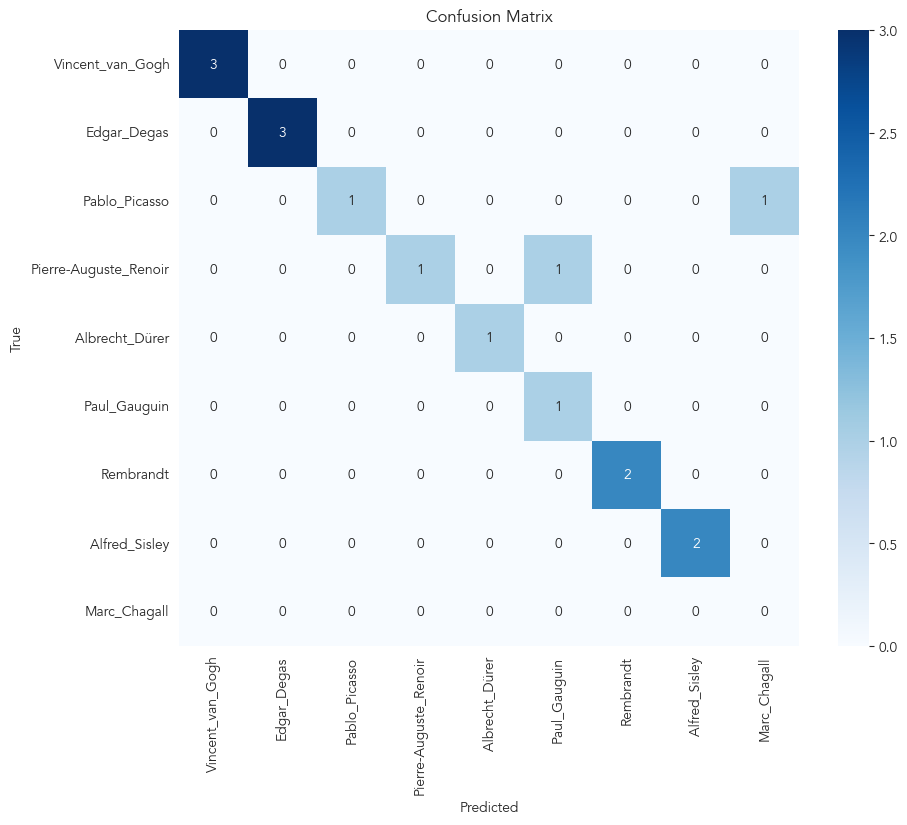

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.multiclass import unique_labels

# Your class labels
class_labels = {
    0: 'Vincent_van_Gogh',
    1: 'Edgar_Degas',
    2: 'Pablo_Picasso',
    3: 'Pierre-Auguste_Renoir',
    4: 'Albrecht_Dürer',
    5: 'Paul_Gauguin',
    6: 'Francisco_Goya',
    7: 'Rembrandt',
    8: 'Alfred_Sisley',
    9: 'Titian',
    10: 'Marc_Chagall'
}

# Calculate the confusion matrix
cm = confusion_matrix(y.argmax(axis=1), y_pred.argmax(axis=1))

# Get class labels in the correct order
classes = [class_labels[i] for i in unique_labels(y.argmax(axis=1), y_pred.argmax(axis=1))]

# Create a Seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [37]:
print(classification_report(y.argmax(axis=1), y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3
           2       1.00      0.50      0.67         2
           3       1.00      0.50      0.67         2
           4       1.00      1.00      1.00         1
           5       0.50      1.00      0.67         1
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         2
          10       0.00      0.00      0.00         0

    accuracy                           0.88        16
   macro avg       0.83      0.78      0.78        16
weighted avg       0.97      0.88      0.90        16



/Users/rohan/miniconda3/envs/tf-metal/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rohan/miniconda3/envs/tf-metal/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rohan/miniconda3/envs/tf-metal/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1/1 [==============================] - 0s 116ms/step


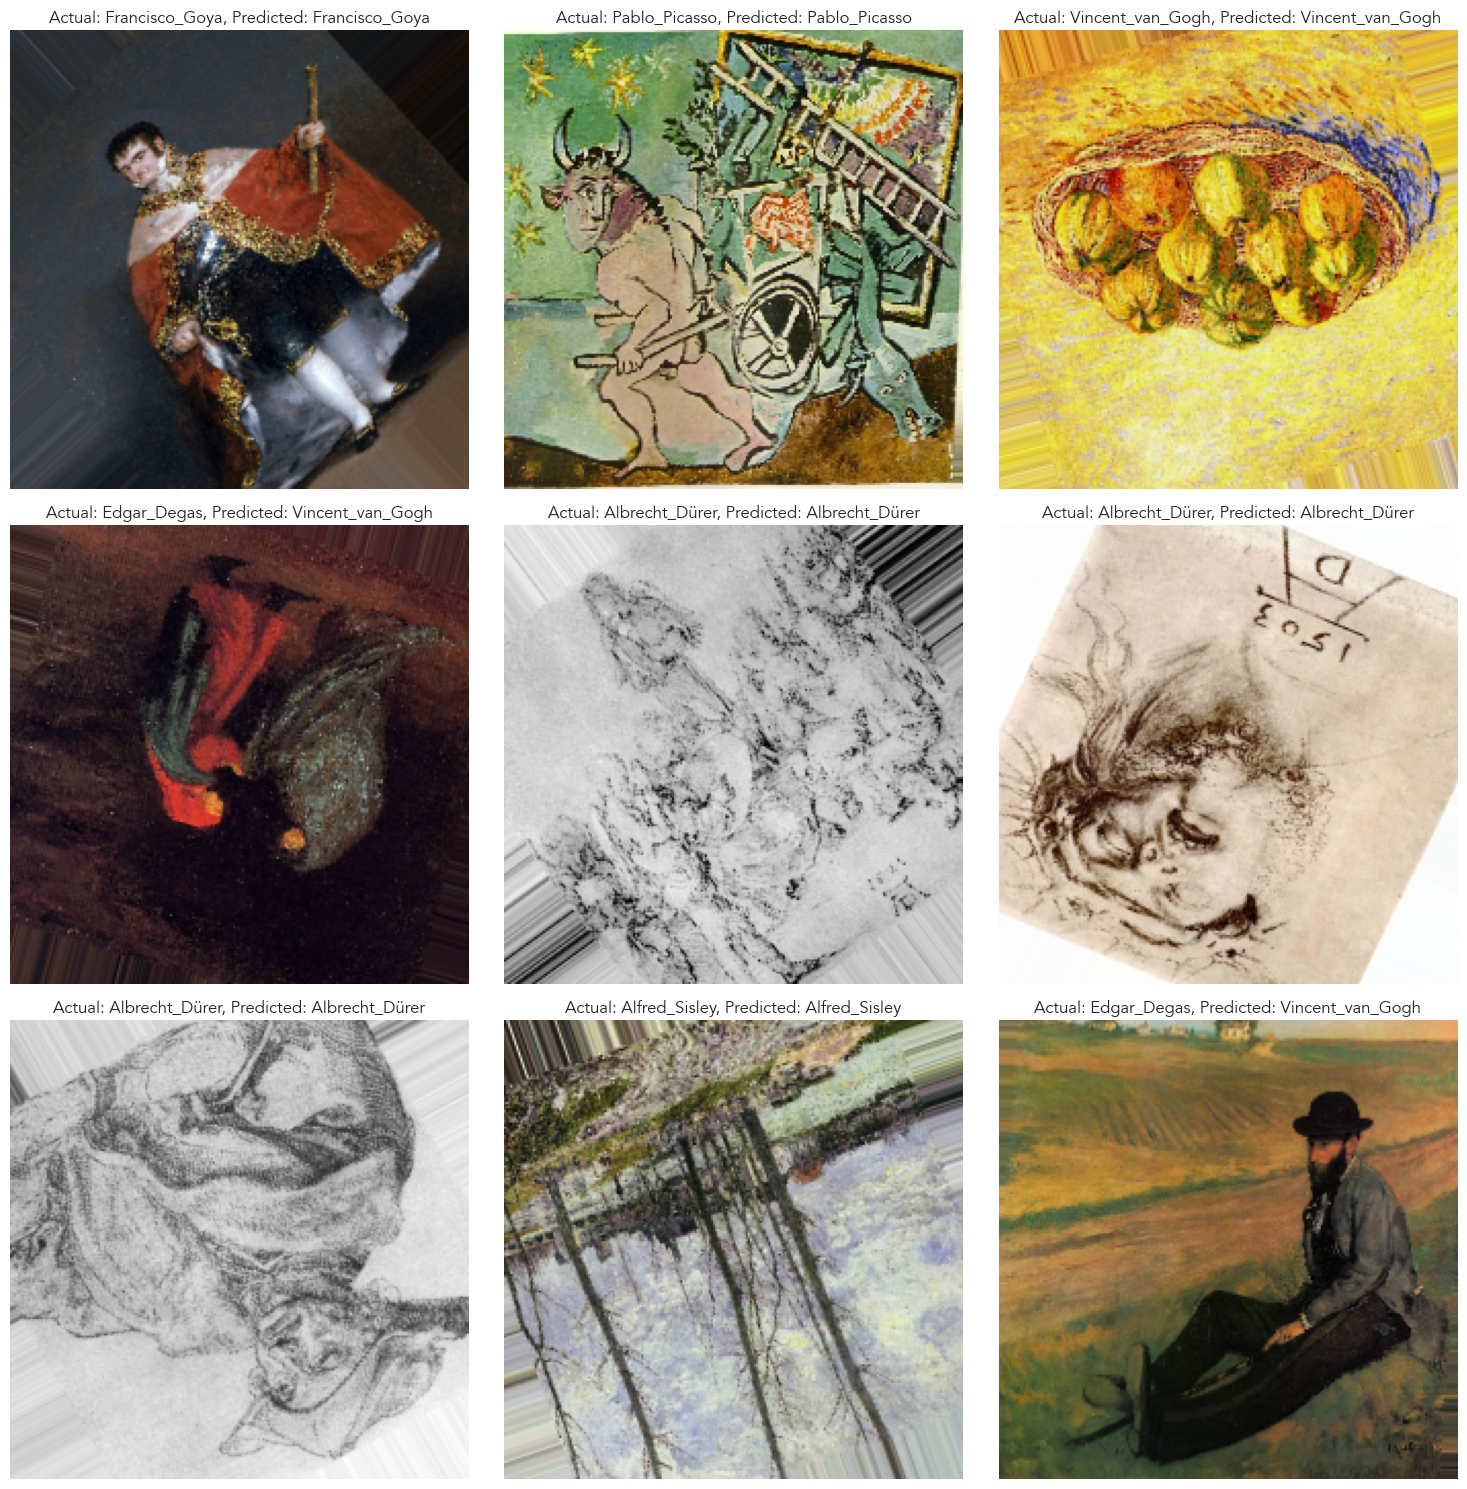

In [39]:
# Load one batch of images and their labels from the validation generator
images, labels = next(valid_generator)

# Make predictions on the batch
predictions = model.predict(images)
predicted_labels = np.argmax(predictions, axis=1)

# Define the number of rows and columns for the facet grid
n_rows = 3
n_cols = 3  # Adjust based on the batch size

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 15))
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < len(images):
        # Display image
        ax.imshow(images[i])

        # Set title with actual and predicted labels
        actual_label = labels[i].argmax()
        predicted_label = predicted_labels[i]
        title = f"Actual: {class_dictionary_f[actual_label]}, Predicted: {class_dictionary_f[predicted_label]}"
        ax.set_title(title)

        # Hide axis details
        ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:

import sys

import pandas as pd
import sklearn as sk
import tensorflow as tf
import matplotlib.pyplot as plt 
import seaborn as sns 
import keras
import os
import platform

print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")


plt.rcParams['font.family'] = 'avenir'

import tensorflow as tf
import keras.preprocessing.image as process_im
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
from keras.applications import vgg19
from keras.models import Model
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K
import functools
from PIL import Image
import numpy as np
from tensorflow.keras.preprocessing import image as process_im


# SET IMAGE PATHS

content_path='./tobe_transferred/IMG_3232.jpeg'
style_path = '../images/images/Henri_Rousseau/Henri_Rousseau_66.jpg'


def load_file(image_path):
    image = Image.open(image_path)
    max_dim = 512
    factor = max_dim / max(image.size)
    image = image.resize((round(image.size[0] * factor), round(image.size[1] * factor)), Image.ADAPTIVE)
    im_array = process_im.img_to_array(image)
    im_array = np.expand_dims(im_array, axis=0)  # Adding an extra axis to generate a batch of a single image
    return im_array


def show_im(img,title=None):
    img=np.squeeze(img,axis=0) #squeeze array to drop batch axis
    plt.imshow(np.uint8(img))
    if title is None:
        pass
    else:
        plt.title(title)
    plt.imshow(np.uint8(img))
    
    
content = load_file(content_path)
style = load_file(style_path)


plt.figure(figsize=(10,10))
content = load_file(content_path)
style = load_file(style_path)
plt.subplot(1,2,1)
show_im(content,'Content Image - My Image of Michigan Ave, Chicago, IL')
plt.subplot(1,2,2)
show_im(style,'Style Image - Henri Rousseau')
plt.show()

def img_preprocess(img_path):
    image=load_file(img_path)
    img=tf.keras.applications.vgg19.preprocess_input(image)
    return img

def deprocess_img(processed_img):
    
    x = processed_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)
    assert len(x.shape) == 3 #Input dimension must be [1, height, width, channel] or [height, width, channel]


    # perform the inverse of the preprocessing step
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1] # converting BGR to RGB channel

    x = np.clip(x, 0, 255).astype('uint8')
    return x

def get_model():
    
    vgg=tf.keras.applications.vgg19.VGG19(include_top=False,weights='imagenet')
    vgg.trainable=False
    content_output=[vgg.get_layer(layer).output for layer in content_layers]
    style_output=[vgg.get_layer(layer).output for layer in style_layers]
    model_output= style_output+content_output
    return models.Model(vgg.input,model_output)


model= tf.keras.applications.vgg19.VGG19(include_top=False,weights='imagenet')
model.summary()

model=get_model()
model.summary()

def get_content_loss(noise,target):
    loss = tf.reduce_mean(tf.square(noise-target))
    return loss

def gram_matrix(tensor):
    channels=int(tensor.shape[-1])
    vector=tf.reshape(tensor,[-1,channels])
    n=tf.shape(vector)[0]
    gram_matrix=tf.matmul(vector,vector,transpose_a=True)
    return gram_matrix/tf.cast(n,tf.float32)


def get_style_loss(noise,target):
    gram_noise=gram_matrix(noise)
    #gram_target=gram_matrix(target)
    loss=tf.reduce_mean(tf.square(target-gram_noise))
    return loss
    
def get_features(model,content_path,style_path):
    content_img=img_preprocess(content_path)
    style_image=img_preprocess(style_path)
    
    content_output=model(content_img)
    style_output=model(style_image)
    
    content_feature = [layer[0] for layer in content_output[number_style:]]
    style_feature = [layer[0] for layer in style_output[:number_style]]
    return content_feature,style_feature
    
def compute_loss(model, loss_weights,image, gram_style_features, content_features):
    style_weight,content_weight = loss_weights #style weight and content weight are user given parameters
                                               #that define what percentage of content and/or style will be preserved in the generated image
    
    output=model(image)
    content_loss=0
    style_loss=0
    
    noise_style_features = output[:number_style]
    noise_content_feature = output[number_style:]
    
    weight_per_layer = 1.0/float(number_style)
    for a,b in zip(gram_style_features,noise_style_features):
        style_loss+=weight_per_layer*get_style_loss(b[0],a)
        
    
    weight_per_layer =1.0/ float(number_content)
    for a,b in zip(noise_content_feature,content_features):
        content_loss+=weight_per_layer*get_content_loss(a[0],b)
        
    style_loss *= style_weight
    content_loss *= content_weight
    
    total_loss = content_loss + style_loss
    
    
    return total_loss,style_loss,content_loss

def compute_grads(dictionary):
    with tf.GradientTape() as tape:
        all_loss=compute_loss(**dictionary)
        
    total_loss=all_loss[0]
    return tape.gradient(total_loss,dictionary['image']),all_loss

model=tf.keras.applications.vgg19.VGG19(include_top=False,weights='imagenet')

def run_style_transfer(content_path,style_path,epochs=500,content_weight=1e3, style_weight=1e-2):
    
    model=get_model()
    
    for layer in model.layers:
        layer.trainable = False
        
    content_feature,style_feature = get_features(model,content_path,style_path)
    style_gram_matrix=[gram_matrix(feature) for feature in style_feature]
    
    noise = img_preprocess(content_path)
    noise=tf.Variable(noise,dtype=tf.float32)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=5, beta_1=0.99, epsilon=1e-1)
    
    best_loss,best_img=float('inf'),None
    
    loss_weights = (style_weight, content_weight)
    dictionary={'model':model,
              'loss_weights':loss_weights,
              'image':noise,
              'gram_style_features':style_gram_matrix,
              'content_features':content_feature}
    
    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means   
  
    imgs = []
    for i in range(epochs):
        grad,all_loss=compute_grads(dictionary)
        total_loss,style_loss,content_loss=all_loss
        optimizer.apply_gradients([(grad,noise)])
        clipped=tf.clip_by_value(noise,min_vals,max_vals)
        noise.assign(clipped)
        
        if total_loss<best_loss:
            best_loss = total_loss
            best_img = deprocess_img(noise.numpy())
            
         #for visualization   
            
        if i%5==0:
            plot_img = noise.numpy()
            plot_img = deprocess_img(plot_img)
            imgs.append(plot_img)
            IPython.display.clear_output(wait=True)
            IPython.display.display_png(Image.fromarray(plot_img))
            print('Epoch: {}'.format(i))        
            print('Total loss: {:.4e}, ' 
              'style loss: {:.4e}, '
              'content loss: {:.4e}, '.format(total_loss, style_loss, content_loss))
    
    IPython.display.clear_output(wait=True)
    
    
    return best_img,best_loss,imgs

best, best_loss,image = run_style_transfer(content_path, style_path, epochs=500)

#FINAL
plt.figure(figsize=(15,15))
plt.subplot(1,3,3)
plt.imshow(best)
plt.title('Style transfer Image')
plt.xticks([])
plt.yticks([])
plt.subplot(1,3,1)
show_im(content,'Content Image')
plt.xticks([])
plt.yticks([])
plt.subplot(1,3,2)
show_im(style,'Style Image')
plt.xticks([])
plt.yticks([])
plt.show()